In [1]:
%pip install -U 'seaborn' 'nbformat'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'seaborn'"

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

%pip install scikit-learn==1.0.0


In [3]:
%pip install dtreeviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

#import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

In [4]:
## loading the data
training = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_training-set.csv")
testing = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_testing-set.csv")
print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [5]:
# checking if all the columns are similar
all(training.columns == testing.columns)

True

In [6]:
# creating one-whole dataframe which contains all data and drop the 'id' column
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

# print one attack sample
df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0


In [7]:
# getting the attack category column 
df.attack_cat.unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [8]:
# exploring the types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

In [9]:
# some columns should be change from string to categoriacal
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].astype('category').cat.codes
    
df['attack_cat'] = df['attack_cat'].astype('category') # keep the nomical info for attack info

attack_cat
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: count, dtype: int64


<Axes: ylabel='count'>

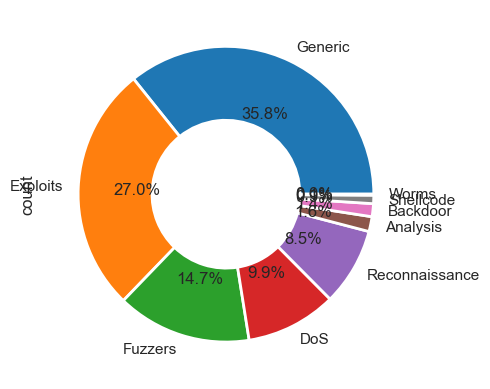

In [10]:
# explore different types of attackes
print(df[df['label']==1]
     ['attack_cat']
     .value_counts()
)

# plot the pie plot of attacks
df[df['label']==1]['attack_cat'].value_counts()\
    .plot\
    .pie(autopct='%1.1f%%',wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'width': 0.50})

In [11]:
# separating the target columns in the training and testing data 
from sklearn.model_selection import train_test_split

# Split the data into variables and target variables
# let's exclude label columns 
X = df.loc[:, ~df.columns.isin(['attack_cat', 'label'])]
y = df['label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Getting the list of variables
feature_names = list(X.columns)

# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


In [13]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_
#same as
#clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion= 'entropy')
#clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the mean absolute error of the model
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


In [ ]:
# plot the tree 
# from sklearn.tree import export_text
# import dtreeviz

# print(":::::::> The RULES FOR HIGH RECALL RATE <::::::: \n" ,export_text(clf,feature_names=feature_names))

# # visualizing the tree
# viz_model = dtreeviz.model(clf,
#                            X_train=X_train, y_train=y_train, 
#                            feature_names=feature_names)

# v = viz_model.view(fancy=True)     # render as SVG into internal object 
# v

In [15]:
X_test = X_test.reset_index(drop=True)

# filter out testing part based on our rules
rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

# getting the index of records to keep
ind = X_test.query(rules).index

# filtering test set (both X_test and y_test)
X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(59425, 42)
filtered data 23.0 %


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_2)

# Calculate the mean absolute error of the model
acc = accuracy_score(y_test_2, y_pred)
rec = recall_score(y_test_2, y_pred)
per = precision_score(y_test_2, y_pred)
print("Recall: ", rec)
print("Percision: ", per)
print("Accuracy: ", acc)

Recall:  0.9574644358228257
Percision:  0.964559074993893
Accuracy:  0.9352797644089188


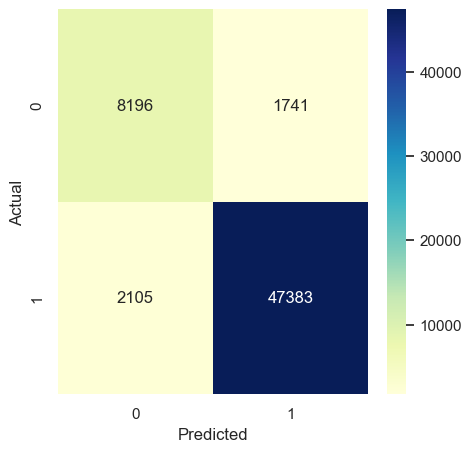

In [17]:
# plot confusion matrix
cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
plt.figure(figsize=(5, 5))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

In [18]:
# save the 100th tree sample in random forest in the file 
from sklearn.tree import export_text
feature_names = list(X.columns)

# Create a file and write to it
with open("Tree_output.txt", "w") as file:
    print(export_text(rf.estimators_[99], 
            spacing=3, decimals=2,
            feature_names=feature_names), file=file)

In [19]:
# creating of ranking data frame
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

# sorting the features based on their importance value
feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

# show only 10 most important feature in style of gradien of colores
feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.139708
1,ct_state_ttl,0.107578
2,rate,0.052387
3,dload,0.049926
4,sload,0.047473
5,sbytes,0.040504
6,ct_dst_src_ltm,0.040064
7,smean,0.039948
8,ct_srv_dst,0.036520
9,dbytes,0.034286


<Axes: >

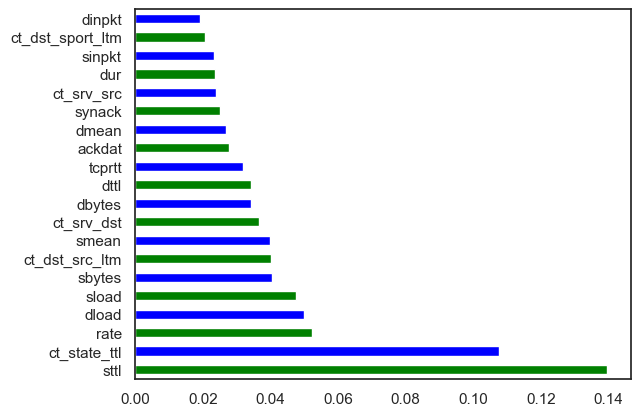

In [20]:
# plot the important features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',color=['g','b']*5)

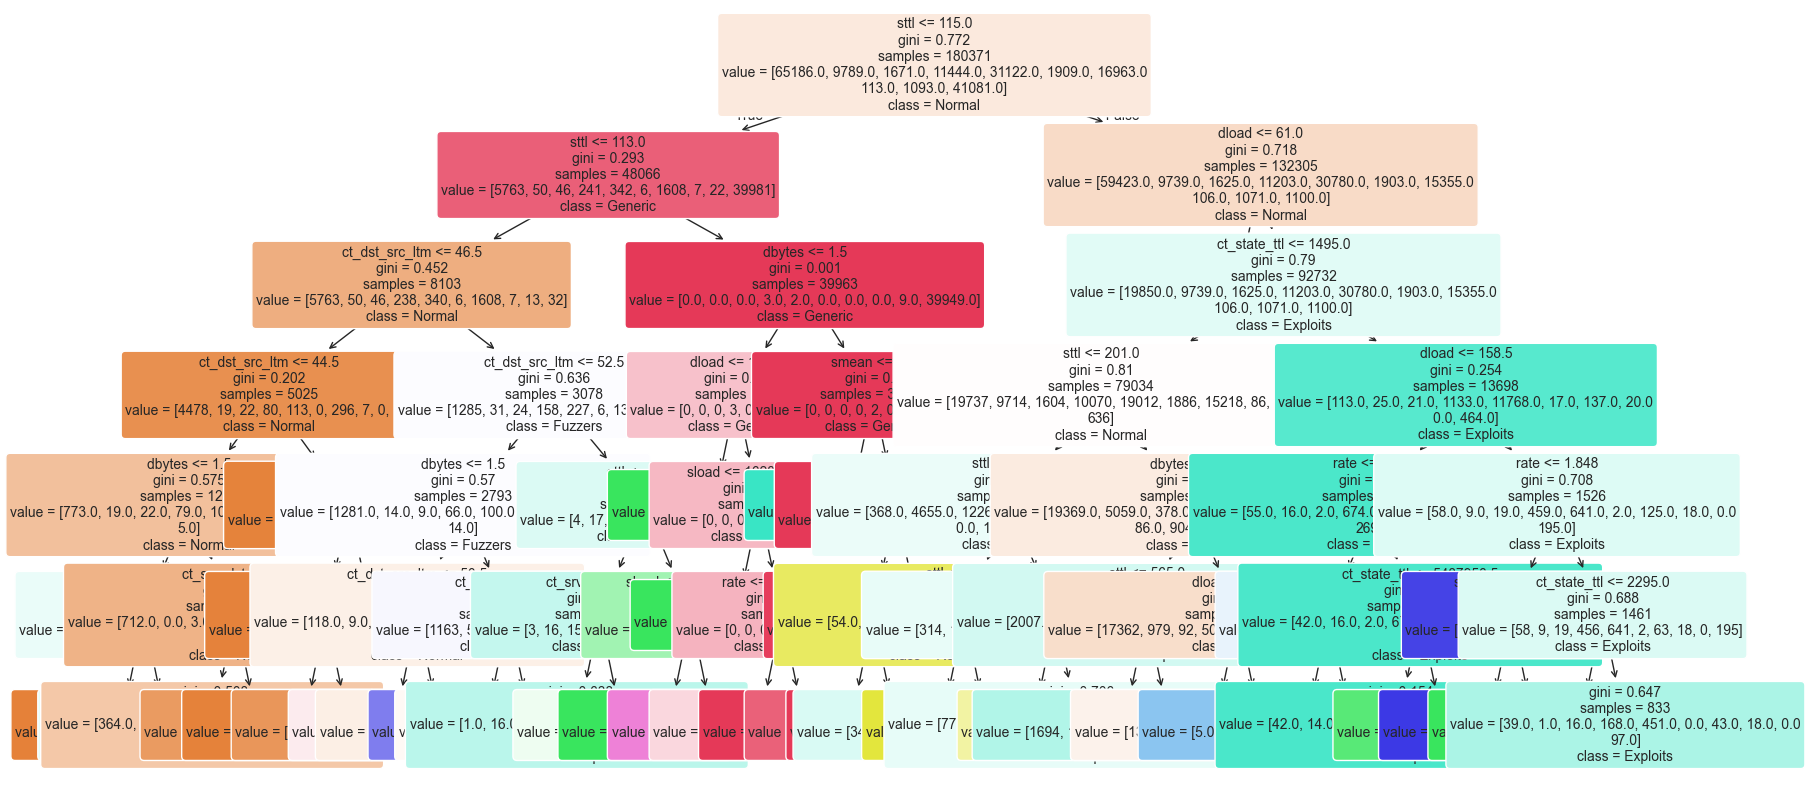

In [21]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the names of top 10 features
top10 = feature_imp.Name[:10].tolist()

# Get the attack names
attack_names = np.array(df['attack_cat'].unique())

# Select only top 10 features
X_top = df.loc[:, df.columns.isin(top10)]

# Convert the categorical data into numbers (e.g., normal -> 0, Backdoor -> 2)
y_top = pd.factorize(df['attack_cat'])[0]

# For the purpose of visualization we set max_depth to 6
clf_top10 = DecisionTreeClassifier(max_depth=6)

# Split the data into train and test sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=11)

# Train the model on the training data
clf_top10.fit(X_train_top, y_train_top)

# Visualize the tree using matplotlib
plt.figure(figsize=(20,10))
plot_tree(clf_top10, feature_names=top10, class_names=attack_names, filled=True, rounded=True, fontsize=10)
plt.show()
